In this assignement, feel free to use the `sparse` module from `scipy`.

Use the cell below for your imports.

#### implement the function `mat_mul_coo` that takes two sparse matrices in `coo` and returns their product.

In [15]:
from collections import defaultdict
from typing import List, Tuple
import numpy as np

def mat_mul_coo(mat1: Tuple[List[int], List[int], List[float]], mat2: Tuple[List[int], List[int], List[float]]):
    if len(mat1[0]) == 0 or len(mat2[0]) == 0:
        return ([], [], [])

    # create dictionary to store intermediate results (used for affectation before declaration)
    # It provides a default value for the key that does not exists.
    intermediate = defaultdict(float)

    # I iterate over the first matrix and populate intermediate dictionary
    for i in range(len(mat1[0])):
        row1 = mat1[0][i]
        col1 = mat1[1][i]
        val1 = mat1[2][i]
        for j in range(len(mat2[0])):
            row2 = mat2[0][j]
            col2 = mat2[1][j]
            val2 = mat2[2][j]
            if col1 == row2:
                intermediate[(row1, col2)] += val1 * val2

    # I convert intermediate dictionary to COO format
    rows = []
    cols = []
    vals = []
    for (row, col), val in intermediate.items():
        rows.append(row)
        cols.append(col)
        vals.append(val)

    return np.array([rows, cols, vals])


In [16]:
# Example test case
mat1 = ([0, 0, 1, 1, 2], [0, 2, 1, 2, 0], [2, 3, 4, 5, 6])
mat2 = ([0, 0, 1, 1, 2, 2], [0, 1, 0, 2, 1, 2], [1, 2, 3, 4, 5, 6])

result = mat_mul_coo(mat1, mat2)

print("mat1:")
print(mat1)
print("mat2:")
print(mat2)
print("result:")
print(result)

mat1:
([0, 0, 1, 1, 2], [0, 2, 1, 2, 0], [2, 3, 4, 5, 6])
mat2:
([0, 0, 1, 1, 2, 2], [0, 1, 0, 2, 1, 2], [1, 2, 3, 4, 5, 6])
result:
[[ 0.  0.  0.  1.  1.  1.  2.  2.]
 [ 0.  1.  2.  0.  2.  1.  0.  1.]
 [ 2. 19. 18. 12. 46. 25.  6. 12.]]


#### implement the function `mat_mul_csr` that takes two sparse matrices in `csr` format and returns their product.

In [23]:
def sparse_matrix_mult(A_data, A_indices, A_indptr, B_data, B_indices, B_indptr):
    """
    Multiplies two sparse matrices in CRS format.
    :param A_data: array of nonzero values in matrix A
    :param A_indices: array of column indices for each nonzero value in matrix A
    :param A_indptr: array of indices into A_data and A_indices indicating where each row of A starts and ends
    :param B_data: array of nonzero values in matrix B
    :param B_indices: array of column indices for each nonzero value in matrix B
    :param B_indptr: array of indices into B_data and B_indices indicating where each row of B starts and ends
    :return: sparse matrix product AB in CRS format
    """
    # get dimensions of A and B
    m, n, p = len(A_indptr) - 1, len(B_indptr) - 1, len(B_indices)
    # initialize result arrays
    C_data, C_indices, C_indptr = [], [], [0]
    # iterate over rows of A
    for i in range(m):
        # create dictionary to store values for row i of C
        C_row = {}
        # iterate over nonzeros in row i of A
        for k in range(A_indptr[i], A_indptr[i+1]):
            # get column index j and value A[i,j]
            j, A_ij = A_indices[k], A_data[k]
            # check that column j of B has nonzero entries
            if j < n:
                # iterate over nonzeros in column j of B
                for l in range(B_indptr[j], B_indptr[j+1]):
                    # get row index k and value B[j,k]
                    k, B_jk = B_indices[l], B_data[l]
                    # add value A[i,j] * B[j,k] to row i of C
                    C_row[k] = C_row.get(k, 0) + A_ij * B_jk
        # append values for row i of C to result arrays
        for k, val in C_row.items():
            C_indices.append(k)
            C_data.append(val)
        C_indptr.append(len(C_indices))
    return C_data, C_indices, C_indptr

In [25]:
from scipy.sparse import csr_matrix
# Define the matrices in CSR format
data1 = np.array([1, 2, 3, 4, 5, 6])
row_ptr1 = np.array([0, 2, 4, 6])
col_ind1 = np.array([0, 1, 1, 2, 2, 3])


data2 = np.array([1, 2, 3, 4, 5, 6])
row_ptr2 = np.array([0, 2, 4, 6])
col_ind2 = np.array([0, 1, 1, 2, 2, 3])


sparse_matrix1 = csr_matrix((data1, col_ind1, row_ptr1))
dense_matrix1 = sparse_matrix1.toarray()

print(dense_matrix1)

sparse_matrix2 = csr_matrix((data2, col_ind2, row_ptr2))
dense_matrix2 = sparse_matrix2.toarray()

print(dense_matrix2)
sparse_matrix_mult(data1, col_ind1, row_ptr1, data1, col_ind1, row_ptr1)

[[1 2 0 0]
 [0 3 4 0]
 [0 0 5 6]]
[[1 2 0 0]
 [0 3 4 0]
 [0 0 5 6]]


([1, 8, 8, 9, 32, 24, 25, 30], [0, 1, 2, 1, 2, 3, 2, 3], [0, 3, 6, 8])

##### implement a function `solve_lin_sys` that takes a matrix `A` in `csr` format and a vector `b` as a numpy array and solves the system `Ax = b`.

In [17]:
import numpy as np
from scipy.sparse import csr_matrix

def solve_lin_sys(A, b):
    # Convert A to CSR format
    A_csr = csr_matrix(A)
    
    # Get the number of rows in A
    n = A_csr.shape[0]
    
    # Initialize the solution vector x
    x = np.zeros(n)
    
    # Iterate over the rows of A
    for i in range(n):
        # Get the indices and data for the non-zero elements in row i
        row_data = A_csr.data[A_csr.indptr[i]:A_csr.indptr[i+1]]
        row_indices = A_csr.indices[A_csr.indptr[i]:A_csr.indptr[i+1]]
        
        # Compute the dot product of row i and x to get the ith element of Ax
        Ax_i = np.dot(row_data, x[row_indices])
        
        # Compute the ith element of x using the formula: x_i = (b_i - Ax_i) / A[i,i]
        x[i] = (b[i] - Ax_i) / A_csr[i,i]
    
    return x


In [18]:
import numpy as np
from scipy.sparse import csr_matrix

# Define a 3x3 matrix A in CSR format
data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
indices = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2])
indptr = np.array([0, 3, 6, 9])
A = csr_matrix((data, indices, indptr), shape=(3, 3))

# Define a 3x1 vector b
b = np.array([1, 2, 3])

# Solve the linear system Ax = b
x = solve_lin_sys(A, b)

# Print the solution
print(x)


[ 1.         -0.4        -0.08888889]


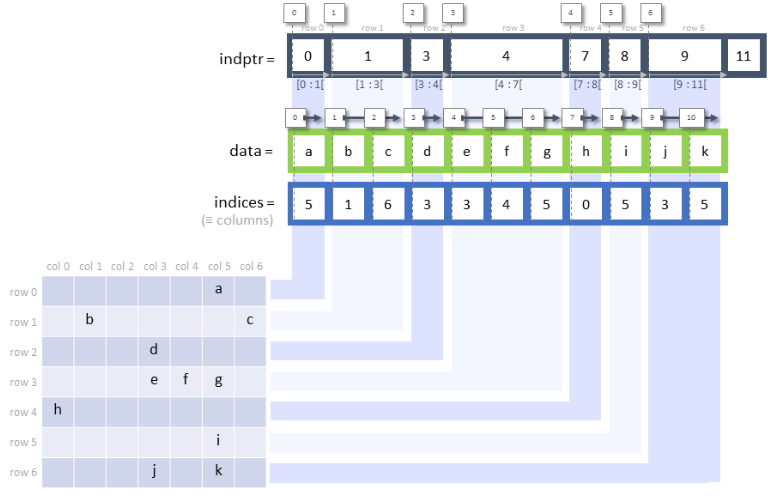

The formula $x_i = (b_i - Ax_i) / A[i,i]$ comes from the standard way of solving a linear system Ax = b using Gaussian elimination with partial pivoting.

In Gaussian elimination, we apply a series of row operations to the augmented matrix [A | b] to transform it into an upper triangular matrix [U | c]. The solution vector x can then be computed by back-substitution starting from the last row of [U | c].